In [1]:
import os
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

In [2]:
skill_scores_long = pd.read_csv('./results/hds_nse_skill/skill_scores.csv')

gauge_info= pd.read_csv('../SMM_Models/hype/geospatial/misc/hype_naturalized_flows_summary.csv', index_col=0)

output_dir = './results/hds_nse_skill/'

plot_prefix = 'hds_nse'

# Define periods and corresponding masks
periods = {
    'calibration': 'cal_mask',
    'validation': 'val_mask',
 #   'all': None  # No mask for 'all'
}

In [3]:
# Create dictionary mapping subbasin_id to Gauge ID
subbasin_to_gauge = gauge_info['Gauge ID'].to_dict()

# Make sure subbasin column is int
skill_scores_long['subbasin'] = skill_scores_long['subbasin'].astype(int)

# Ensure dictionary keys are int
subbasin_to_gauge = {int(k): v for k, v in subbasin_to_gauge.items()}

# Map gauge IDs
skill_scores_long['gauge_id'] = skill_scores_long['subbasin'].map(subbasin_to_gauge)


In [4]:
# ================
# Sort from West to East
# Ensure subbasin_id is the index in gauge_info
gauge_info_sorted = gauge_info.reset_index().sort_values("Longitude")

# Create a dictionary mapping gauge_id to longitude
gauge_order = gauge_info_sorted["Gauge ID"].tolist()

# Make gauge_id categorical in skill_scores_long with the correct order
skill_scores_long['gauge_id'] = pd.Categorical(
    skill_scores_long['gauge_id'],
    categories=gauge_order,
    ordered=True
)

# Optional: sort the DataFrame by gauge_id for plotting
skill_scores_long = skill_scores_long.sort_values(['gauge_id', 'period', 'benchmark']).reset_index(drop=True)


### No CDF

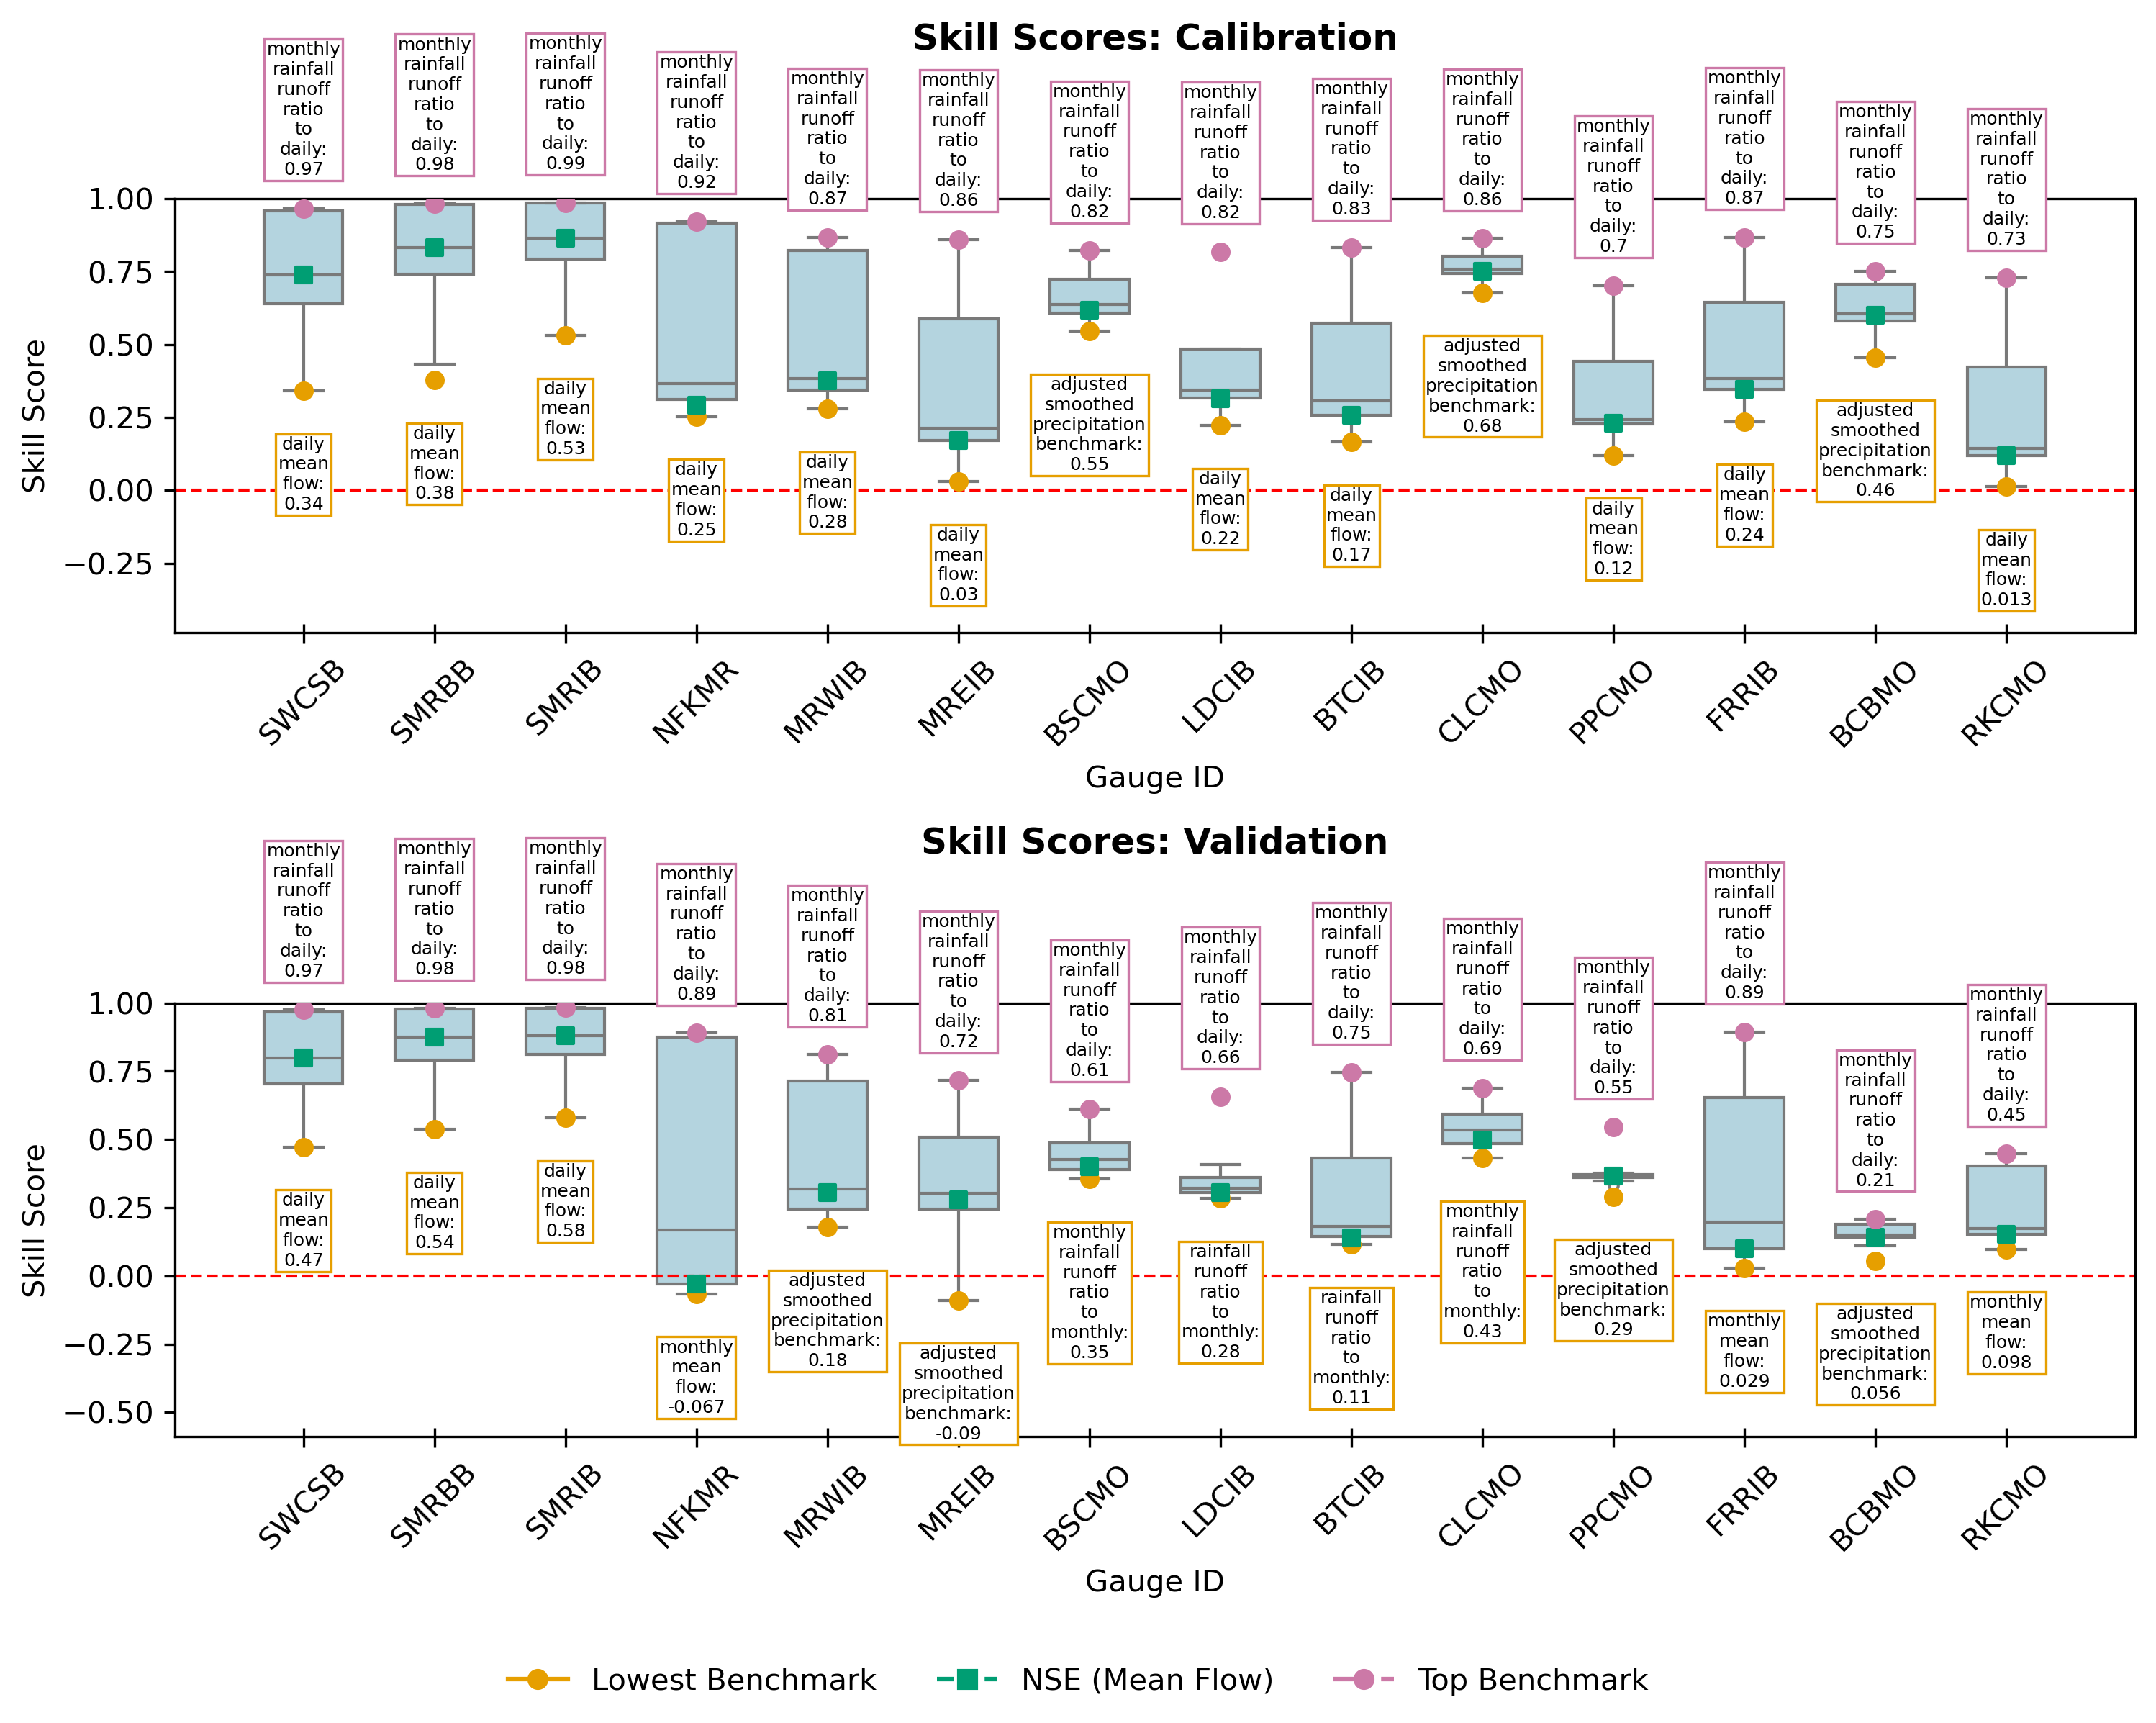

In [5]:
# CB-friendly colours
box_color = "#ADD8E6"  # lighter blue
lowest_benchmark_color = "#E69F00"  # orange
mean_flow_color = "#009E73"         # green
top_benchmark_color = "#CC79A7"     # magenta/purple

fig, axes_box = plt.subplots(
    nrows=len(periods), ncols=1,
    figsize=(10, 4 * len(periods)),
    dpi=300
)

# If only one period, axes_box won't be a list
if len(periods) == 1:
    axes_box = [axes_box]

for ax_box, period in zip(axes_box, periods):
    df_period = skill_scores_long[skill_scores_long['period'] == period].copy()
    df_period['gauge_id'] = pd.Categorical(
        df_period['gauge_id'],
        categories=df_period['gauge_id'].unique(),
        ordered=True
    )

    # -----------------
    # BOX PLOT
    # -----------------
    sns.boxplot(
        x='gauge_id', y='skill_score', data=df_period,
        ax=ax_box, color=box_color, width=0.6, fliersize=3
    )

    # Lowest benchmark
    min_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmin()]
    x_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                   for gid in min_rows['gauge_id']]
    ax_box.scatter(x_positions, min_rows["skill_score"],
                   color=lowest_benchmark_color, s=30, zorder=5)

    # Mean flow (NSE benchmark)
    mean_rows = df_period[df_period['benchmark'] == 'bm_mean_flow']
    x_mean_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                        for gid in mean_rows['gauge_id']]
    ax_box.scatter(x_mean_positions, mean_rows["skill_score"],
                   color=mean_flow_color, s=30, zorder=5, marker='s')

    # Top benchmark
    max_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmax()]
    x_max_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                       for gid in max_rows['gauge_id']]
    ax_box.scatter(x_max_positions, max_rows["skill_score"],
                   color=top_benchmark_color, s=30, zorder=5, marker='o')

    # Horizontal line
    ax_box.axhline(0, color='red', linestyle='--', linewidth=1)

    # Y limits
    y_min = df_period['skill_score'].min() - 0.5
    y_max = 1
    ax_box.set_ylim(y_min, y_max)

    # Annotations for lowest benchmark
    for row, x_pos in zip(min_rows.itertuples(), x_positions):
        label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
        value_text = f"{row.skill_score:.2g}"
        ax_box.annotate(
            f"{label_text}:\n{value_text}",
            (x_pos, row.skill_score),
            textcoords="offset points", xytext=(0, -15), ha="center", va="top",
            fontsize=6, color="black",
            bbox=dict(facecolor='white', edgecolor=lowest_benchmark_color, linewidth=0.8, pad=0.7, alpha=1)
        )
    
    # Annotations for top benchmark
    for row, x_pos in zip(max_rows.itertuples(), x_max_positions):
        label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
        value_text = f"{row.skill_score:.2g}"
        edge_color = top_benchmark_color if row.benchmark != 'bm_mean_flow' else mean_flow_color
        ax_box.annotate(
            f"{label_text}:\n{value_text}",
            (x_pos, row.skill_score),
            textcoords="offset points", xytext=(0, 10), ha="center", va="bottom",
            fontsize=6, color="black",
            bbox=dict(facecolor='white', edgecolor=edge_color, linewidth=0.8, pad=0.7, alpha=1)
        )

    ax_box.set_title(f"Skill Scores: {period.capitalize()}", fontsize=12, weight='bold', pad=50)
    ax_box.set_ylabel("Skill Score", fontsize=10)
    ax_box.set_xlabel("Gauge ID", fontsize=10)
    ax_box.tick_params(axis="x", rotation=45)

    # Little vertical lines above the x-axis labels
    for x in range(len(df_period['gauge_id'].cat.categories)):
        ax_box.vlines(x, ymin=y_min, ymax=y_min + 0.02*(y_max - y_min), color='black', linewidth=0.8)

# Legend once for all
fig.legend(
    handles=[
        plt.Line2D([0], [0], color=lowest_benchmark_color, marker="o", label="Lowest Benchmark"),
        plt.Line2D([0], [0], color=mean_flow_color, linestyle="--", marker="s", label="NSE (Mean Flow)"),
        plt.Line2D([0], [0], color=top_benchmark_color, linestyle="-.", marker="o", label="Top Benchmark")
    ],
    loc="lower center", ncol=3, frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])

# # Save figures
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_skill_scores_boxplot.pdf'), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_skill_scores_boxplot.png'), dpi=300, bbox_inches="tight")

plt.show()


### CDF

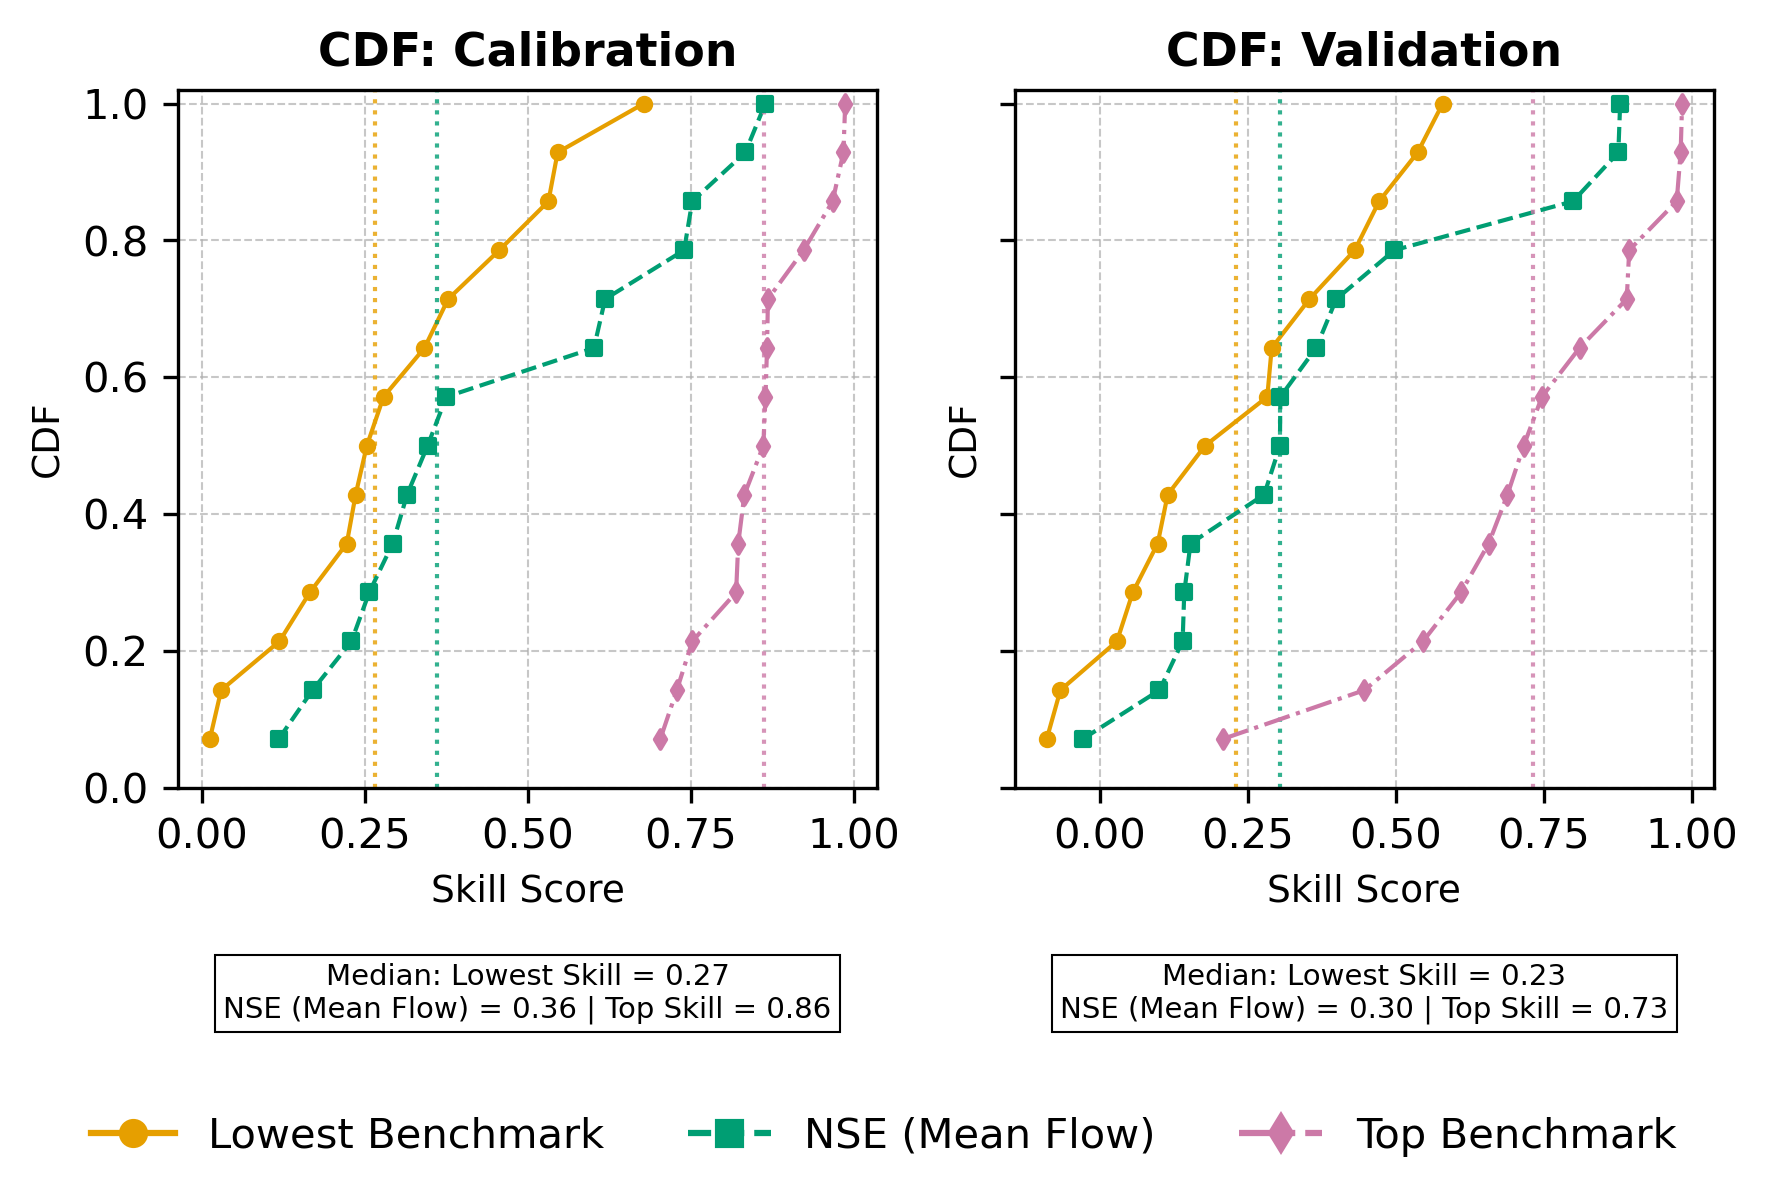

In [6]:
# ==============================
# CDFs only, 1 row, multiple columns
# ==============================
periods_list = list(periods)  # ensure it's iterable
n_periods = len(periods_list)

fig_cdf, axes_cdf = plt.subplots(1, n_periods, figsize=(3*n_periods, 4), dpi=300, sharey=True)

# Ensure axes_cdf is iterable even if only one subplot
if n_periods == 1:
    axes_cdf = [axes_cdf]

for ax_cdf, period in zip(axes_cdf, periods_list):
    df_period = skill_scores_long[skill_scores_long['period'] == period].copy()

    # Lowest, mean, and top benchmark scores
    min_rows  = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmin()]
    mean_rows = df_period[df_period['benchmark'] == 'bm_mean_flow']
    max_rows  = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmax()]

    lowest_vals = min_rows["skill_score"].values
    mean_vals   = mean_rows["skill_score"].values
    top_vals    = max_rows["skill_score"].values

    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(x)+1) / len(x)
        return x, y

    median_texts = []

    for vals, color, label, ls, marker in [
        (lowest_vals, lowest_benchmark_color, "Lowest Skill", "-", "o"),
        (mean_vals, mean_flow_color, "NSE (Mean Flow)", "--", "s"),
        (top_vals, top_benchmark_color, "Top Skill", "-.", "d")
    ]:
        if len(vals) > 0:
            x, y = ecdf(vals)
            ax_cdf.plot(x, y, color=color, linestyle=ls, label=label, linewidth=1)
            ax_cdf.scatter(x, y, color=color, s=10, marker=marker, zorder=5)

            # Median line
            median_val = np.median(vals)
            ax_cdf.axvline(median_val, color=color, linestyle=":", linewidth=1, alpha=0.8)
            median_texts.append((label, median_val, color))

    # Add median text once
    if median_texts:
        lower_label, lower_val, lower_color = median_texts[0]
        others = median_texts[1:]
        label_text = f"Median: {lower_label} = {lower_val:.2f}\n"
        if others:
            label_text += " | ".join([f"{lbl} = {val:.2f}" for lbl, val, c in others])
        ax_cdf.text(
            0.5, -0.25, label_text,
            ha="center", va="top", transform=ax_cdf.transAxes,
            fontsize=7, color="black",
            bbox=dict(facecolor="white", edgecolor="black", linewidth=0.5, alpha=1, pad=2)
        )

    ax_cdf.set_title(f"CDF: {period.capitalize()}", fontsize=11, weight='bold')
    ax_cdf.set_xlabel("Skill Score", fontsize=9)
    ax_cdf.set_ylabel("CDF", fontsize=9)
    ax_cdf.set_ylim(0, 1.02)
    ax_cdf.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Shared legend
fig_cdf.legend(
    handles=[
        plt.Line2D([0], [0], color=lowest_benchmark_color, marker="o", label="Lowest Benchmark"),
        plt.Line2D([0], [0], color=mean_flow_color, linestyle="--", marker="s", label="NSE (Mean Flow)"),
        plt.Line2D([0], [0], color=top_benchmark_color, linestyle="-.", marker="d", label="Top Benchmark")
    ],
    loc="lower center", ncol=3, frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])

# Save figure
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_CDF_only.png'), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_CDF_only.pdf'), dpi=300, bbox_inches="tight")

plt.show()


### With CDF

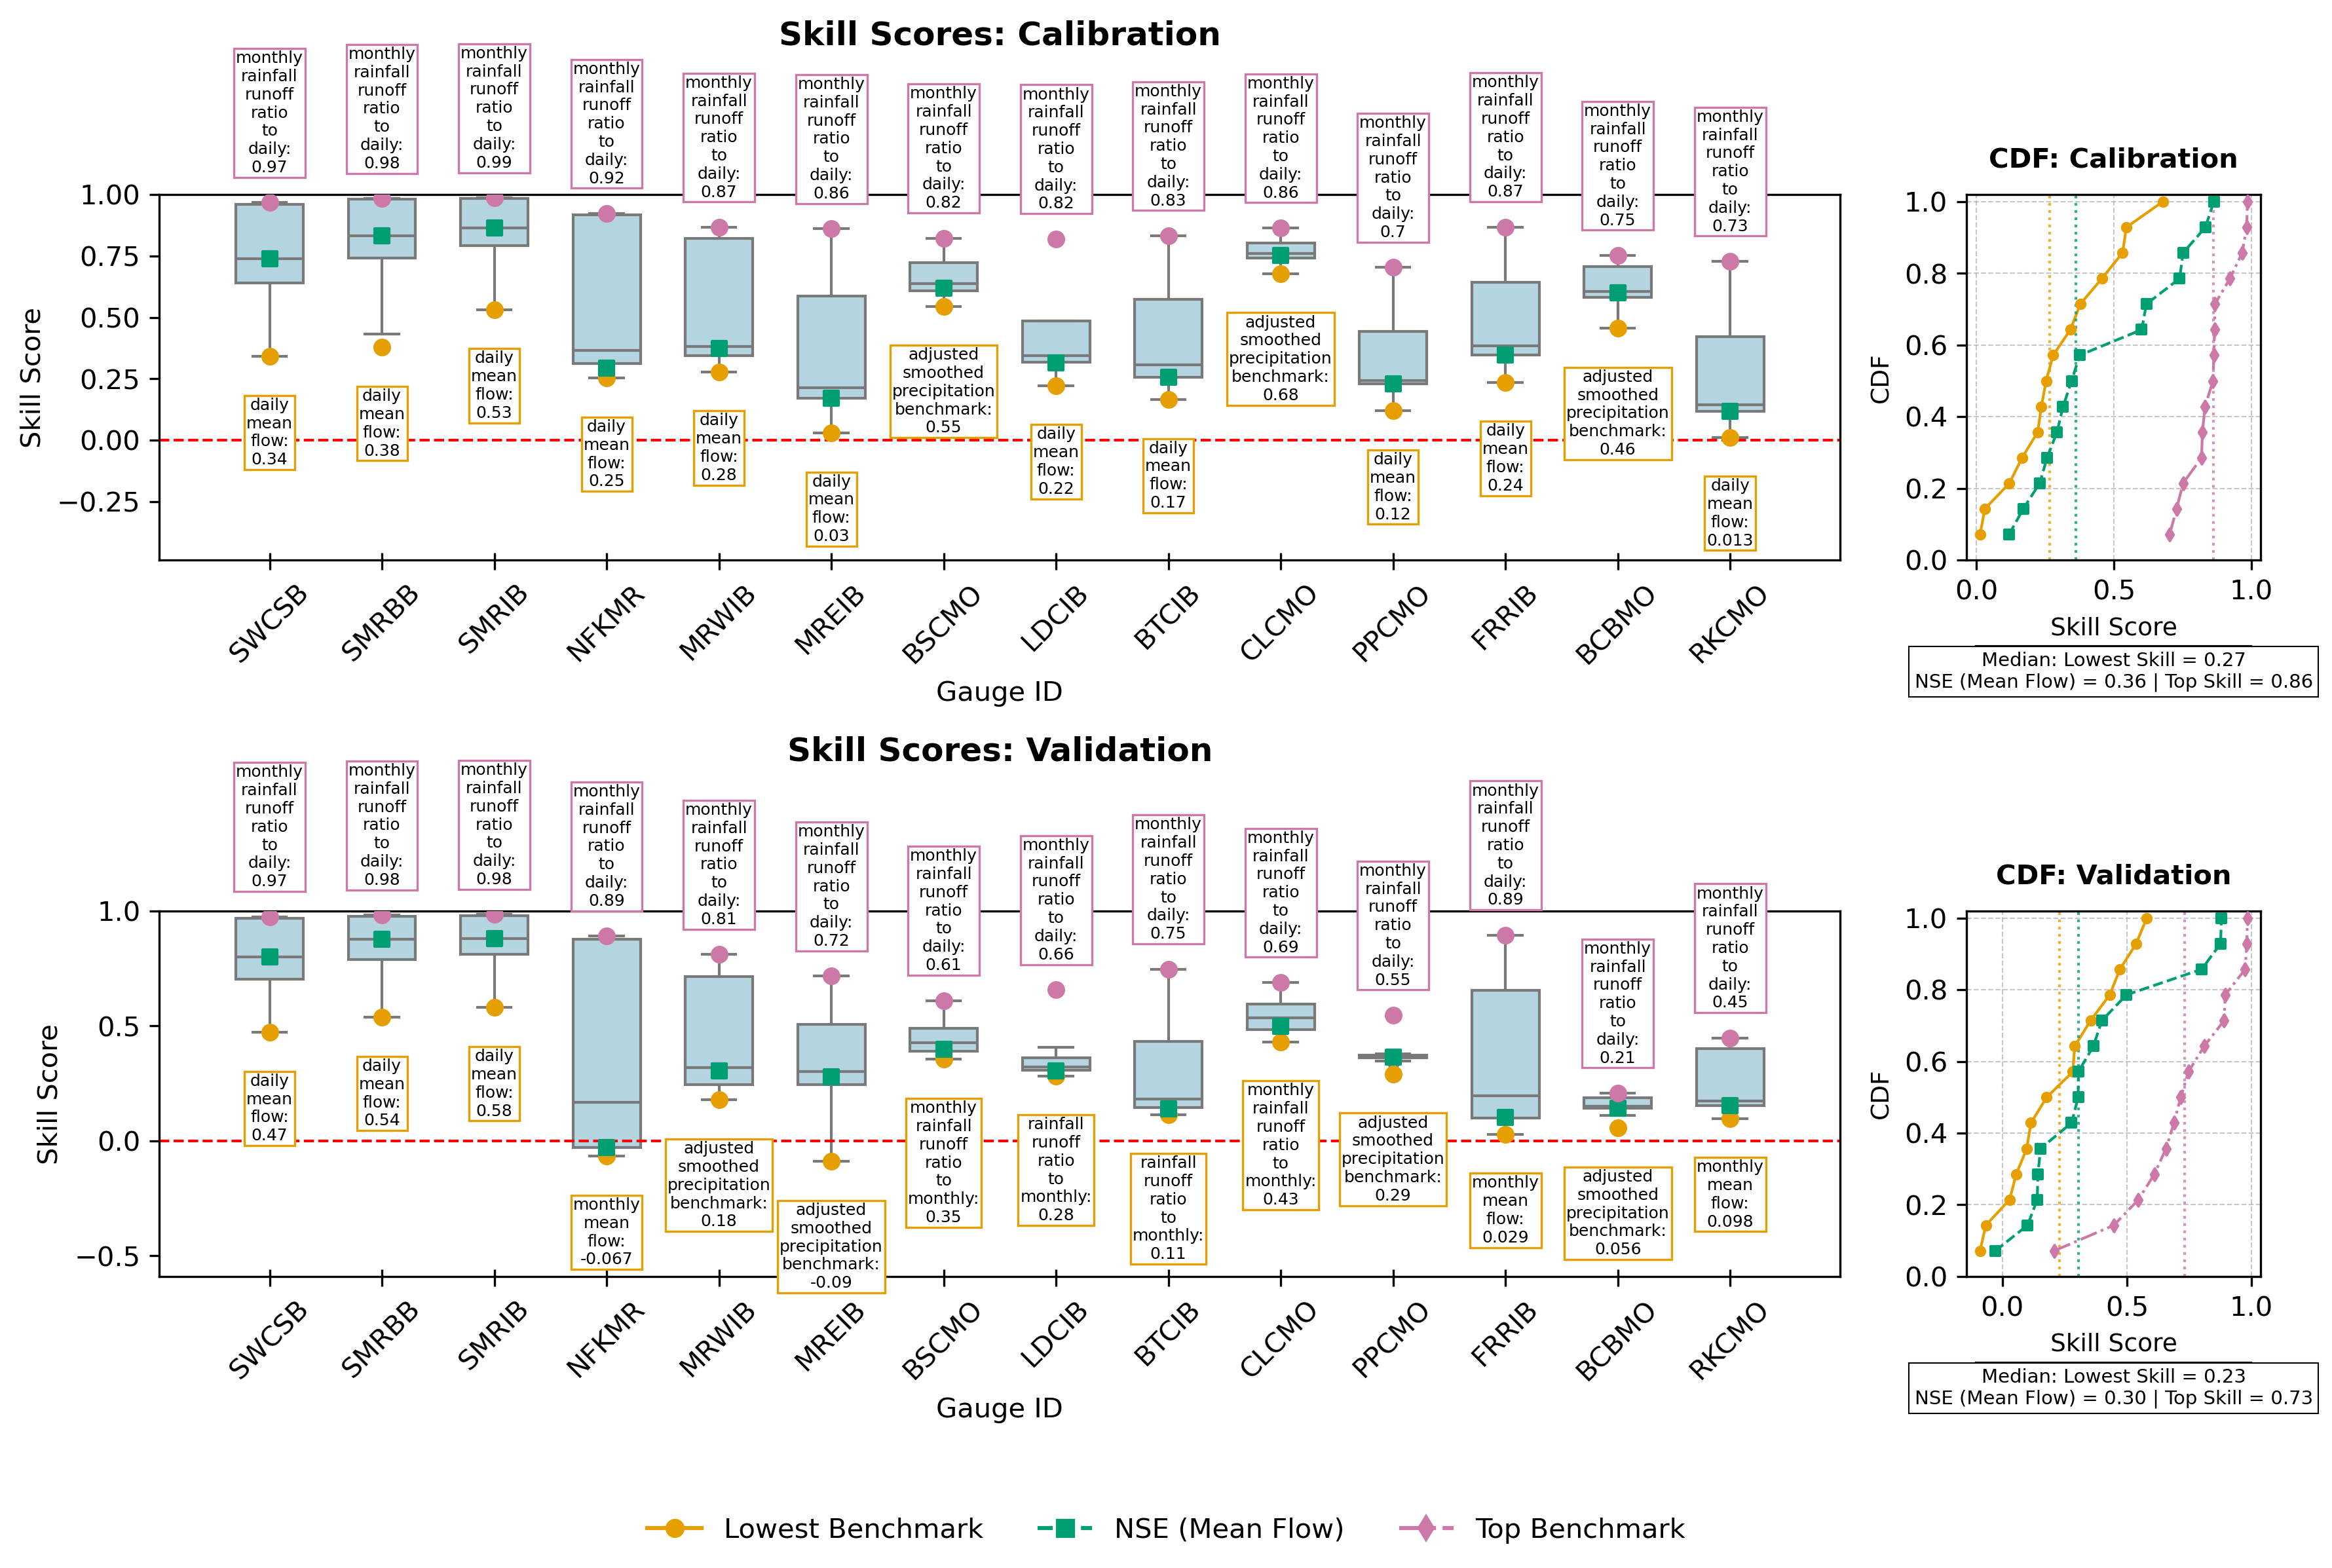

In [7]:
# CB-friendly colours
box_color = "#ADD8E6"  # lighter blue
lowest_benchmark_color = "#E69F00"  # orange
mean_flow_color = "#009E73"         # green
top_benchmark_color = "#CC79A7"  # magenta/purple

# Custom layout: 2 columns per row (boxplot + CDF)
fig = plt.figure(figsize=(12, 8), dpi=300)
gs = GridSpec(len(periods), 2, width_ratios=[4, 0.7], figure=fig)

axes_box = []
axes_cdf = []

for i, period in enumerate(periods):
    ax_box = fig.add_subplot(gs[i, 0])
    ax_cdf = fig.add_subplot(gs[i, 1])  # no sharey
    axes_box.append(ax_box)
    axes_cdf.append(ax_cdf)

    df_period = skill_scores_long[skill_scores_long['period'] == period].copy()
    df_period['gauge_id'] = pd.Categorical(
        df_period['gauge_id'],
        categories=df_period['gauge_id'].unique(),
        ordered=True
    )

    # -----------------
    # BOX PLOT
    # -----------------
    sns.boxplot(
        x='gauge_id', y='skill_score', data=df_period,
        ax=ax_box, color=box_color, width=0.6, fliersize=3
    )

    # Lowest benchmark
    min_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmin()]
    x_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                   for gid in min_rows['gauge_id']]
    ax_box.scatter(x_positions, min_rows["skill_score"],
                   color=lowest_benchmark_color, s=30, zorder=5)

    # Mean flow (NSE benchmark)
    mean_rows = df_period[df_period['benchmark'] == 'bm_mean_flow']
    x_mean_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                        for gid in mean_rows['gauge_id']]
    ax_box.scatter(x_mean_positions, mean_rows["skill_score"],
                   color=mean_flow_color, s=30, zorder=5, marker='s')

    # Top benchmark
    max_rows = df_period.loc[df_period.groupby("subbasin")["skill_score"].idxmax()]
    x_max_positions = [np.where(df_period['gauge_id'].cat.categories == gid)[0][0]
                       for gid in max_rows['gauge_id']]
    ax_box.scatter(x_max_positions, max_rows["skill_score"],
                   color=top_benchmark_color, s=30, zorder=5, marker='o')

    # Horizontal line
    ax_box.axhline(0, color='red', linestyle='--', linewidth=1)

    # Y limits
    y_min = df_period['skill_score'].min() - 0.5
    y_max = 1
    ax_box.set_ylim(y_min, y_max)

    # Annotations for lowest benchmark
    for row, x_pos in zip(min_rows.itertuples(), x_positions):
        label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
        value_text = f"{row.skill_score:.2g}"
        ax_box.annotate(
            f"{label_text}:\n{value_text}",
            (x_pos, row.skill_score),
            textcoords="offset points", xytext=(0, -15), ha="center", va="top",
            fontsize=6, color="black",
            bbox=dict(facecolor='white', edgecolor=lowest_benchmark_color, linewidth=0.8, pad=0.7, alpha=1)
        )
    
    # Annotations for top benchmark
    for row, x_pos in zip(max_rows.itertuples(), x_max_positions):
        label_text = row.benchmark.replace("bm_", "").replace("_", "\n")
        value_text = f"{row.skill_score:.2g}"
        # choose color depending on whether it's top or mean
        edge_color = top_benchmark_color if row.benchmark != 'bm_mean_flow' else mean_flow_color
        ax_box.annotate(
            f"{label_text}:\n{value_text}",
            (x_pos, row.skill_score),
            textcoords="offset points", xytext=(0, 10), ha="center", va="bottom",
            fontsize=6, color="black",
            bbox=dict(facecolor='white', edgecolor=edge_color, linewidth=0.8, pad=0.7, alpha=1)
        )

    ax_box.set_title(f"Skill Scores: {period.capitalize()}", fontsize=12, weight='bold', pad=55)
    ax_box.set_ylabel("Skill Score", fontsize=10)
    ax_box.set_xlabel("Gauge ID", fontsize=10)
    ax_box.tick_params(axis="x", rotation=45)

    # Add little vertical lines above the x-axis labels
    for x in range(len(df_period['gauge_id'].cat.categories)):
        ax_box.vlines(x, ymin=y_min, ymax=y_min + 0.02*(y_max - y_min), color='black', linewidth=0.8)

    # -----------------
    # CDF PLOT
    # -----------------
    lowest_vals = min_rows["skill_score"].values
    mean_vals   = mean_rows["skill_score"].values
    top_vals    = max_rows["skill_score"].values
    
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y
    
    median_texts = []
    
    for vals, color, label, ls, marker in [
        (lowest_vals, lowest_benchmark_color, "Lowest Skill", "-", "o"),
        (mean_vals, mean_flow_color, "NSE (Mean Flow)", "--", "s"),
        (top_vals, top_benchmark_color, "Top Skill", "-.", "d")
    ]:
        x, y = ecdf(vals)
        ax_cdf.plot(x, y, color=color, linestyle=ls, label=label, linewidth=1)
        ax_cdf.scatter(x, y, color=color, s=10, marker=marker, zorder=5)
    
        # --- Median vertical line ---
        if len(vals) > 0:
            median_val = np.median(vals)
            ax_cdf.axvline(median_val, color=color, linestyle=":", linewidth=1, alpha=0.8)
            median_texts.append((label, median_val, color))
    
        # --- Draw median text box once ---
        if median_texts:
            # Separate lowest median
            lower_label, lower_val, lower_color = median_texts[0]
            others = median_texts[1:]
            
            # Put line break **after lowest median only**
            label_text = f"Median: {lower_label} = {lower_val:.2f}\n"
            
            if others:
                label_text += " | ".join([f"{lbl} = {val:.2f}" for lbl, val, c in others])
            
            ax_cdf.text(
                0.5, -0.25, label_text,
                ha="center", va="top", transform=ax_cdf.transAxes,
                fontsize=7, color="black",
                bbox=dict(facecolor="white", edgecolor="black", linewidth=0.5, alpha=1, pad=2)
            )

    
    ax_cdf.set_title(f"CDF: {period.capitalize()}", fontsize=10, weight='bold', pad=10)
    ax_cdf.set_xlabel("Skill Score", fontsize=9)
    ax_cdf.set_ylabel("CDF", fontsize=9)
    ax_cdf.set_ylim(0, 1.02)
    ax_cdf.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Legend once for all
fig.legend(
    handles=[
        plt.Line2D([0], [0], color=lowest_benchmark_color, marker="o", label="Lowest Benchmark"),
        plt.Line2D([0], [0], color=mean_flow_color, linestyle="--", marker="s", label="NSE (Mean Flow)"),
        plt.Line2D([0], [0], color=top_benchmark_color, linestyle="-.", marker="d", label="Top Benchmark")
    ],
    loc="lower center", ncol=3, frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])

# Save figures
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_CDF_skill_scores_boxplot.pdf'), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_dir, f'{plot_prefix}_CDF_skill_scores_boxplot.png'), dpi=300, bbox_inches="tight")

plt.show()
